# Implement of priciple curvatures of adaptive radius

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd
import skdim
from scipy.stats import pearsonr

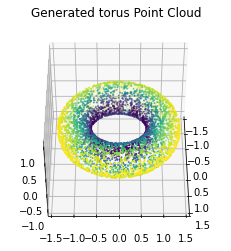

In [4]:
def generate_torus_point_cloud(num_points = 5000, R = 3, r = 1):
    # Generate random angles for theta and phi
    theta = np.random.uniform(0, 2*np.pi, num_points)
    phi = np.random.uniform(0, 2*np.pi, num_points)

    # Compute the torus points
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)
    
    x_c = R * np.cos(theta)
    y_c = R * np.sin(theta)
    z_c = np.zeros(x.shape)
    
    K = np.cos(phi)/(r * (R + r * np.cos(phi))) 
    
    

    return np.column_stack((x, y, z)), np.column_stack((x_c, y_c, z_c)), K

# Create torus parameters
R = 1 # Major radius
r = 0.375  # Minor radius
num_samples = 5000



# Generate a torus point cloud with 1000 points and radius 1
torus, torus_centers, torus_K = generate_torus_point_cloud(num_points = num_samples, R = R, r = r)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(torus[:, 0], torus[:, 1], torus[:, 2], s=1, c = torus_K)
#ax.scatter(torus[0, 0], torus[0, 1], torus[0, 2], s=10, c = 'r')
#ax.scatter(torus_centers[:, 0], torus_centers[:, 1], torus_centers[:, 2], s=5, c = 'r')
ax.set_aspect('equal')
ax.set_title("Generated torus Point Cloud")
ax.view_init(45, 0)
plt.show()

In [10]:
def epsilon_and_tau(point_cloud, query):
    ratio_all = []
    for i in range(1, 100):
        epsilon_PCA = 0.01 * i
        nbrs = NearestNeighbors(n_neighbors=2500, algorithm='ball_tree').fit(point_cloud)
        ep_dist, ep_idx = nbrs.radius_neighbors(query, epsilon_PCA, return_distance=True, sort_results = True)

        pca_nbrs = point_cloud[ep_idx[0]]
        Xi = pca_nbrs - query
        Di = np.diag(np.sqrt(np.exp(-1*np.array(ep_dist[0]) ** 2 / epsilon_PCA)))
        Bi = Xi.T @ Di
    
        U, S, VT = np.linalg.svd(Bi.T, full_matrices = True)
        if len(S)>= 2: 
            ratio = (S[0]+ S[1])/sum(S)
        else:
            ratio = 1.0
        ratio_all.append(ratio)
    tau = 0.01 * np.argmin(np.array(ratio_all) - min(ratio_all))
    eps_PCA = 0.01 * np.argmin(np.abs(np.array(ratio_all) - 0.85))
    return eps_PCA, tau


In [11]:
def find_basis(point_cloud, x,  extrin_dim = 3):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the point where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    
    # Find transport neighborhood
    k = int(0.05 * point_cloud.shape[0])
    
    epsilon_PCA, tau = epsilon_and_tau(point_cloud, x)


    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)
    ep_dist, ep_idx = nbrs.radius_neighbors(x, epsilon_PCA, return_distance=True, sort_results = True)
    
       
    
    #tau_dist, tau_idx = nbrs.kneighbors(x, k, return_distance=True)
    tau_dist, tau_idx = nbrs.radius_neighbors(x, tau, return_distance=True, sort_results = True)
    
    tau_nbrs = point_cloud[tau_idx[0]]
    
    
    pca_nbrs = point_cloud[ep_idx[0]]
    Xi = pca_nbrs - x
    Di = np.diag(np.sqrt(np.exp(- np.array(ep_dist[0]) ** 2 / epsilon_PCA)))
    Bi = Xi.T @ Di
    
    U, S, VT = np.linalg.svd(Bi.T, full_matrices = False)
    O = VT[:extrin_dim, :]
    
    return tau_nbrs[1:], tau_dist[0][1:], epsilon_PCA, O
   
    
        
    

#this is the new one for tau automatically tuned
def compute_curvature_adaptive(point_cloud, query_point, extrin_dim = 3, use_cross = True):
    
    tau_nbrs, tau_dist, epsilon_PCA, O = find_basis(point_cloud, query_point, extrin_dim = extrin_dim)
 
    if use_cross:
        O2 = np.cross(O[0], O[1])
    else:
        O2 = O[2]

    ti = tau_nbrs - query_point[0]
    norms = np.square(ti).sum(axis=1)
    tensor_all = 2 * (O2 * ti).sum(axis=1) / norms
    
    
    max_min_num = int(0.3 * len(tau_nbrs))
    #max_min_num = 250
    
    max_indices = np.argsort(tensor_all)[-max_min_num: ]
    max_cur = tensor_all[max_indices]
    
    min_indices = np.argsort(tensor_all)[:max_min_num]
    min_cur = tensor_all[min_indices]
    
    max_cur_weight = np.sqrt(np.exp(-np.array(tau_dist[max_indices]) ** 2 / epsilon_PCA))
    min_cur_weight = np.sqrt(np.exp(-np.array(tau_dist[min_indices]) ** 2 / epsilon_PCA))
    
    principal_cur1 = sum(max_cur_weight * max_cur)/sum(max_cur_weight)
    principal_cur2 = sum(min_cur_weight * min_cur)/sum(min_cur_weight)
    #principal_cur1 = sum(max_cur)/len(max_cur)
    #principal_cur2 = sum(min_cur)/len(min_cur)
    
    return principal_cur1 * principal_cur2, (principal_cur1 + principal_cur2)/2
 

## Gaussian curvature and mean curvature

In [ ]:
num_eval = int(len(torus))
gaussian_cur = []
mean_cur = []
for i in tqdm(range(num_eval)):
    g, m = compute_curvature_adaptive(torus, torus[i].reshape(1, -1))
    gaussian_cur.append(g)
    mean_cur.append(m)
    

 12%|█▏        | 605/5000 [07:09<44:54,  1.63it/s]  

In [ ]:
v = np.array(gaussian_cur).T
# Visualize the point cloud

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus[:num_eval, 0], torus[:num_eval, 1], torus[:num_eval, 2], s=2, c = v)
ax.set_title("Gaussian curvature, ep_PCA = 0.2, tau is chosen according to the eigenvalue ratio plot")
ax.view_init(90, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

In [ ]:
v = np.array(mean_cur).T
# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus[:num_eval, 0], torus[:num_eval, 1], torus[:num_eval, 2], s=2, c = -v)
ax.set_title("Curvature on point cloud, ep_PCA = 0.2, tau_radius = 1, max_min = 80")
ax.view_init(90, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

## On ellipsoid

In [ ]:
def generate_ellipsoid_cloud(a, b, c, num_points = 5000):
    """Generate a random point on an ellipsoid defined by a,b,c"""
    
    theta = np.random.uniform(0, 2*np.pi, num_points)
    v = np.random.rand(num_points)
    phi = np.arccos(2.0 * v - 1.0)
    sinTheta = np.sin(theta);
    cosTheta = np.cos(theta);
    sinPhi = np.sin(phi);
    cosPhi = np.cos(phi);
    rx = a * sinPhi * cosTheta;
    ry = b * sinPhi * sinTheta;
    rz = c * cosPhi;
    K = 1 / (a **2 * b**2 * c**2 * (rx**2 / a**4 + ry**2 / b**4 + rz**2 / c**4) **2)
    return np.column_stack((rx, ry, rz)), K

In [ ]:
ellipsoid, ellip_K = generate_ellipsoid_cloud(0.9, 1.5, 0.9)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ellipsoid[:, 0], ellipsoid[:, 1], ellipsoid[:, 2], s=5, c = ellip_K)
ax.set_aspect('equal')
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(0, 0)
plt.show()

In [ ]:
num_eval = int(len(ellipsoid))
gaussian_cur = []
mean_cur = []
for i in tqdm(range(num_eval)):
    g, m = compute_curvature_adaptive(ellipsoid, ellipsoid.reshape(1, -1))
    gaussian_cur.append(g)
    mean_cur.append(m)
    

In [ ]:
v = np.array(gaussian_cur).T

In [59]:
corr, _ = pearsonr(ellip_K , v)
corr

0.9811735828516694